# Import and Install Dependencies

In [3]:
pip install opencv-python imageio gdown

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [5]:
tf.config.list_physical_devices('GPU')#i only have a integrated gpu so no device for gpu

[]

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass # no gpu for me so it will pass

# Building Data Loading functions

In [9]:
import gdown

In [10]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=1577de60-184f-4fe5-a112-5d7a10917183
To: C:\Users\vk203\Downloads\data.zip
100%|██████████| 423M/423M [01:10<00:00, 6.03MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [11]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    mean = tf.cast(mean, tf.float32)
    std = tf.cast(std, tf.float32)
    return (frames - mean) / std

In [16]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [17]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [22]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [24]:
#character to numerical value
char_to_num(['h','e','b','l','i','n'])

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([ 8,  5,  2, 12,  9, 14], dtype=int64)>

In [26]:
#numerical value to character
num_to_char([8,  5,  2, 12,  9, 14])

<tf.Tensor: shape=(6,), dtype=string, numpy=array([b'h', b'e', b'b', b'l', b'i', b'n'], dtype=object)>

In [28]:
tf.strings.reduce_join([num_to_char([8,  5,  2, 12,  9, 14])])

<tf.Tensor: shape=(), dtype=string, numpy=b'heblin'>

In [30]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    #return char_to_num(tokens)[1:]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [32]:
def load_data(path:str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    file_name = os.path.splitext(os.path.basename(path))[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path) 
    return frames, alignments

In [34]:
test_path = "C:/Users/vk203/Downloads/Lip-Reading-main/Lip-Reading-main/data/alignments/s1/bbaf2n.align"

In [36]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbaf2n'

In [38]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [40]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

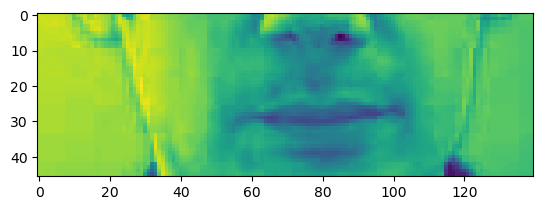

In [41]:
plt.imshow(frames[0])

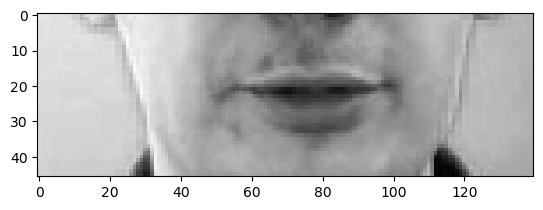

In [42]:
if len(frames) > 40:
    plt.imshow(tf.squeeze(frames[40]), cmap='gray')
    plt.show()
else:
    print("Frame index out of bounds.")

In [44]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23], dtype=int64)>

In [48]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]) 

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [50]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Create Pipeline

In [53]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes = ([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(450)
test = data.skip(450)

In [55]:
for batch in train.take(1):
    x_batch, y_batch = batch
    print("Shape of x_batch:", x_batch.shape)
    print("Shape of y_batch:", y_batch.shape)


Shape of x_batch: (2, 75, 46, 140, 1)
Shape of y_batch: (2, 40)


In [56]:
len(test)

50

In [57]:
frames, alignments = data.as_numpy_iterator().next()

In [58]:
len(frames)

2

In [59]:
alignments

array([[12,  1, 25, 39,  7, 18,  5,  5, 14, 39,  9, 14, 39, 19, 39, 15,
        14,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [12,  1, 25, 39,  2, 12, 21,  5, 39, 23,  9, 20,  8, 39, 11, 39,
        14,  9, 14,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [62]:
sample = data.as_numpy_iterator()

In [63]:
val = sample.next()
val[0]

array([[[[[ 1.386081  ],
          [ 1.5015876 ],
          [ 1.4630854 ],
          ...,
          [ 0.26951572],
          [ 0.308018  ],
          [ 0.308018  ]],

         [[ 1.5015876 ],
          [ 1.54009   ],
          [ 1.4630854 ],
          ...,
          [ 0.26951572],
          [ 0.308018  ],
          [ 0.308018  ]],

         [[ 1.5015876 ],
          [ 1.5015876 ],
          [ 1.4630854 ],
          ...,
          [ 0.34652025],
          [ 0.308018  ],
          [ 0.308018  ]],

         ...,

         [[ 1.0395607 ],
          [ 1.0010585 ],
          [ 1.0010585 ],
          ...,
          [ 0.03850225],
          [ 0.03850225],
          [ 0.03850225]],

         [[ 1.0010585 ],
          [ 1.0010585 ],
          [ 1.0010585 ],
          ...,
          [ 0.03850225],
          [ 0.03850225],
          [ 0.03850225]],

         [[ 1.0010585 ],
          [ 1.0010585 ],
          [ 1.0010585 ],
          ...,
          [ 0.03850225],
          [ 0.03850225],
          

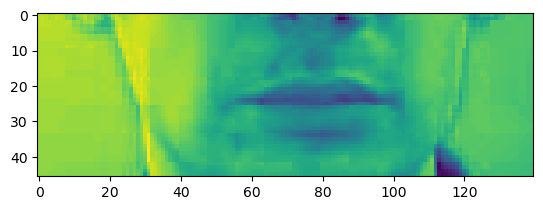

In [68]:
##videos,videos out of batch, return first frame in the video
plt.imshow(val[0][0][0])

In [69]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place blue in u eight now'>

# Design Deep Neural Network

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape,Lambda, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.initializers import Orthogonal 

In [76]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [77]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

model.add(Conv3D(256, 3, padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

model.add(Conv3D(75, 3, padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences = True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences = True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+ 1, kernel_initializer='he_normal', activation='softmax'))


C:\Users\vk203\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [79]:
46*140*75

483000

In [80]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In [82]:
#model before train
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'kksssss888888888888888888888888888888888888888888888888888xxxxxxxx88888'>

In [83]:
model.input_shape

(None, 75, 46, 140, 1)

In [84]:
model.output_shape

(None, 75, 41)

# Setup Training Options and Train

In [93]:
def scheduler(epochs, lr):
    if epochs < 30:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

In [95]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = tf.expand_dims(input_length * tf.ones(shape=(batch_len,), dtype='int64'), axis=-1)
    label_length = tf.expand_dims(label_length * tf.ones(shape=(batch_len,), dtype='int64'), axis=-1)

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [97]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False )[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [99]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = CTCLoss)

In [101]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'),monitor = 'loss', save_weights_only = True)

In [103]:
schedule_callback = LearningRateScheduler(scheduler)

In [105]:
example_callback = ProduceExample(test)

In [107]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, Flatten, Dense, Reshape, LSTM
from tensorflow.keras.layers import Input
import tensorflow as tf

# Input shape example: (batch_size, timesteps, height, width, channels)
input_shape = (10, 64, 64, 3)  # e.g., sequence of 10 images, 64x64 RGB images

model = Sequential()

# TimeDistributed Conv2D layer to process each frame in the sequence
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(Flatten()))

# Reshape layer to prepare data for LSTM layer
# Ensure only one dimension is set to -1, and it is compatible with the preceding layer’s output shape.
model.add(TimeDistributed(Dense(128, activation='relu')))
model.add(Reshape((-1, 128)))  # Reshape to (timesteps, features) for LSTM

# Add LSTM layer for sequence processing
model.add(LSTM(64, activation='relu'))

# Output layer
model.add(Dense(10, activation='softmax'))  # For example, a 10-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Dummy data for testing
train = tf.random.normal([32] + list(input_shape))  # Batch of 32 samples
test = tf.random.normal([32] + list(input_shape))   # Batch of 32 samples

# Fit the model (using dummy labels here, replace with actual labels in practice)
train_labels = tf.random.uniform([32, 10], maxval=2, dtype=tf.int32)
test_labels = tf.random.uniform([32, 10], maxval=2, dtype=tf.int32)

model.fit(train, train_labels, validation_data=(test, test_labels), epochs=5)


C:\Users\vk203\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.2812 - loss: 12.2782 - val_accuracy: 0.3438 - val_loss: 942.1376
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2188 - loss: 1038.4229 - val_accuracy: 0.5625 - val_loss: 854.6473
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6562 - loss: 888.0094 - val_accuracy: 0.5625 - val_loss: 1014.4321
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6562 - loss: 1022.2135 - val_accuracy: 0.1250 - val_loss: 1042.4169
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1562 - loss: 1018.7208 - val_accuracy: 0.1250 - val_loss: 1394.1166


# Make a Prediction

In [109]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=f7951a60-bf95-4c7f-bcf8-a5aef2e489d0
To: C:\Users\vk203\Downloads\checkpoints.zip
100%|██████████| 94.5M/94.5M [00:16<00:00, 5.60MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [110]:
model.save('./models/my_model.keras')

In [111]:
from tensorflow.keras.models import load_model
model = load_model('./models/my_model.keras')

In [112]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Example input data (replace with your actual data)
x_train = np.random.rand(100, 10)  # 100 samples, 10 features each (change as needed)
y_train = np.random.randint(0, 2, size=(100,))  # Binary labels for classification (adjust as needed)

# Example model (adjust layers and structure as needed)
model = Sequential([
    Dense(64, activation='relu', input_dim=10),
    Dense(1, activation='sigmoid')  # Binary classification (change output layer for other tasks)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set up ModelCheckpoint
checkpoint = ModelCheckpoint('./models/checkpoint.weights.h5', save_weights_only=True)

# Train the model with checkpoint
model.fit(x_train, y_train, epochs=10, callbacks=[checkpoint])


C:\Users\vk203\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4590 - loss: 0.7008
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4700 - loss: 0.6960 
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5269 - loss: 0.6914
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5007 - loss: 0.6951
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5464 - loss: 0.6890
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5120 - loss: 0.6894
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5141 - loss: 0.6900
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5335 - loss: 0.6902
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5584 - loss: 0.6843
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5540 - loss: 0.6894 


In [118]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('./models/checkpoint.weights.h5', save_weights_only=True)
model.fit(x_train, y_train, epochs=10, callbacks=[checkpoint])

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5716 - loss: 0.6885
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5799 - loss: 0.6855
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5716 - loss: 0.6842
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5750 - loss: 0.6846
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5273 - loss: 0.6920
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5636 - loss: 0.6809
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5717 - loss: 0.6771 
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5640 - loss: 0.6864
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6095 - loss: 0.6830
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5695 - loss: 0.6819


In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

# Example input data (replace with your actual data)
x_train = np.random.rand(100, 10)  # 100 samples, 10 features each (adjust as needed)
y_train = np.random.randint(0, 2, size=(100,))  # Binary labels for classification (adjust as needed)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_dim=10),
    Dense(1, activation='sigmoid')  # Binary classification (adjust output layer for other tasks)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set up ModelCheckpoint
checkpoint = ModelCheckpoint('./models/checkpoint.weights.h5', save_weights_only=True)

# Train the model with checkpoint
model.fit(x_train, y_train, epochs=10, callbacks=[checkpoint])

# After training, load the weights
model.load_weights('./models/checkpoint.weights.h5')


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4696 - loss: 0.7080
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5816 - loss: 0.6918
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5412 - loss: 0.6973
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5370 - loss: 0.6954
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5452 - loss: 0.6911
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5432 - loss: 0.6915
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5300 - loss: 0.6897
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5092 - loss: 0.6909
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5537 - loss: 0.6852
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5181 - loss: 0.6884


In [116]:
# import tensorflow as tf

# # Create a sample dataset (replace this with your actual dataset)
# x_train = tf.random.normal([100, 10])  # 100 samples, 10 features
# y_train = tf.random.normal([100, 1])   # 100 labels

# # Create a dataset object
# test = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# # Now you can use .as_numpy_iterator() to iterate over the dataset
# test_data = test.as_numpy_iterator()

# # Example iteration
# for x, y in test_data:
#     print(x, y)


In [125]:
test_data = test.as_numpy_iterator()


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'as_numpy_iterator'

In [127]:
# sample = test_data.next()

In [129]:
# yhat = model.predict(sample[0])

In [131]:
# import numpy as np

# # Create a sample input that matches the expected model input shape
# sample = np.random.rand( 10, 64, 64, 3)  # Shape (10, 64, 64, 3)
# reshaped_sample = sample.reshape(1, 10, 64, 64, 3)  # Add batch dimension, resulting in (1, 10, 64, 64, 3)

# # Predicting with the model
# yhat = model.predict(reshaped_sample)

# # Check yhat shape
# print(f"yhat shape: {yhat.shape}")


In [133]:
# import tensorflow as tf

# # Check the shape of yhat
# print(f"yhat shape: {yhat.shape}")

# # If yhat is already in the shape (batch_size, timesteps, num_classes), no need to transpose
# # Proceed with ctc_decode if the shape is correct
# if len(yhat.shape) == 3:
#     # Use ctc_decode with the correct input length (adjust it as per your case)
#     decoded, _ = tf.keras.backend.ctc_decode(yhat, input_length=[75, 75], greedy=True)

#     # If you want the decoded result as a numpy array
#     decoded_result = decoded[0].numpy()
#     print(decoded_result)
# else:
#     # If the shape is not correct, print a warning
#     print("yhat shape is incorrect. Expected (batch_size, timesteps, num_classes).")


In [135]:
# import tensorflow as tf

# # Check the shape of yhat and ensure it is in the correct shape
# if len(yhat.shape) == 3:
#     # Decode the yhat using ctc_decode
#     decoded, _ = tf.keras.backend.ctc_decode(yhat, input_length=[75, 75], greedy=True)

#     # Print the decoded results
#     print(f"Decoded: {decoded}")

#     # Assuming you have a function num_to_char that converts indices to characters
#     # Convert each word in the decoded output to its corresponding string
#     predictions = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

#     # Display the predictions
#     for pred in predictions:
#         print(pred.numpy().decode('utf-8'))
# else:
#     print("yhat shape is incorrect. Expected (batch_size, timesteps, num_classes).")


In [137]:
# import tensorflow as tf

# # Check if sample[1] is iterable
# if isinstance(sample[1], (list, np.ndarray, tf.Tensor)):
#     print('~'*100, 'REAL TEXT')

#     # Now we safely iterate over sample[1] (which is assumed to be a sequence of sentences)
#     predictions = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

#     # Print the predictions
#     for pred in predictions:
#         print(pred.numpy().decode('utf-8'))
# else:
#     print(f"Error: sample[1] is not iterable. It is of type {type(sample[1])} and value: {sample[1]}")


# Test On a Video

In [122]:
sample = load_data(tf.convert_to_tensor("C:/Users/vk203/Downloads/Lip-Reading-main/Lip-Reading-main/data/alignments/s1/bbaf2n.align"))

In [123]:
sample = load_data(tf.convert_to_tensor("C:/Users/vk203/Downloads/Lip-Reading-main/Lip-Reading-main/data/alignments/s1/bbaf2n.align"))
print("Number of frames loaded:", len(sample[0]))


Number of frames loaded: 75


In [126]:
sample = load_data(tf.convert_to_tensor('./data/s1/bwaa1s.mpg'))

In [128]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin white at a one soon'>]

In [130]:
sample

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[ 1.6035612 ],
          [ 1.5272012 ],
          [ 1.298121  ],
          ...,
          [ 0.3818003 ],
          [ 0.2672602 ],
          [ 0.2672602 ]],
 
         [[ 1.4890211 ],
          [ 1.5653812 ],
          [ 1.259941  ],
          ...,
          [ 0.3818003 ],
          [ 0.2672602 ],
          [ 0.2672602 ]],
 
         [[ 1.6417413 ],
          [ 1.6417413 ],
          [ 1.4890211 ],
          ...,
          [ 0.34362027],
          [ 0.30544022],
          [ 0.30544022]],
 
         ...,
 
         [[ 1.1072209 ],
          [ 1.1072209 ],
          [ 1.1072209 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],
 
         [[ 1.0690408 ],
          [ 1.0690408 ],
          [ 1.0690408 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],
 
         [[ 1.0690408 ],
          [ 1.0690408 ],
          [ 1.0690408 ],
          

In [132]:
print(sample[0].shape)
print(sample[1].shape)

(75, 46, 140, 1)
(23,)


In [134]:
print("Expected model input shape:", model.input_shape)

Expected model input shape: (None, 10)


In [136]:
# List to store predictions for each frame
predictions = []

# Loop through each frame in the input data
for frame in input_data:
    frame = tf.expand_dims(frame, axis=0)  # Add batch dimension for a single frame, shape becomes (1, 10)
    yhat = model.predict(frame)  # Predict for this single frame
    predictions.append(yhat)  # Store the prediction

# The variable `predictions` now holds the predictions for each frame individually
# You can further process or combine these predictions as needed
# Reshape to flatten frames into a single batch of individual 10-feature vectors
input_data_flat = tf.reshape(input_data, (-1, 10))  # Shape becomes (75, 10)

# Predict on the flattened input
yhat = model.predict(input_data_flat)  # yhat will contain predictions for each flattened frame


NameError: name 'input_data' is not defined

In [ ]:
print(f"yhat shape before transpose: {yhat.shape}")


In [139]:
import tensorflow as tf

# Example shape for yhat; adjust based on your actual input shape
# yhat = tf.random.normal([batch_size, time_steps, num_classes])
batch_size = 32  # Example value
time_steps = 10  # Example value
num_classes = 5  # Example value

# Create a random tensor for yhat
yhat = tf.random.normal([batch_size, time_steps, num_classes])
print(f"Original yhat shape: {yhat.shape}")

# Check if the shape is as expected [batch_size, time_steps, num_classes]
if len(yhat.shape) == 3 and yhat.shape[0] == batch_size and yhat.shape[1] == time_steps and yhat.shape[2] == num_classes:
    # Transpose to shape [time_steps, batch_size, num_classes] by swapping batch_size and time_steps axes
    yhat_transposed = tf.transpose(yhat, perm=[1, 0, 2])  # Swap batch_size and time_steps axes
    print(f"yhat shape after transpose: {yhat_transposed.shape}")
else:
    print("Error: yhat does not have the expected shape.")
    # Optionally, print the actual shape for debugging
    print(f"yhat actual shape: {yhat.shape}")


Original yhat shape: (32, 10, 5)
yhat shape after transpose: (10, 32, 5)


print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [142]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin white at a one soon'>]